# Introduction: BPNet optimization, validation, and downstream processing 

The purpose of this notebook is to train a BPNet model we can use to interpret 6 TFs (Zelda, Dorsal, Twist, Caudal, Bicoid, and GAGA factor). To do this we will:

1. Optimize the model based on input parameters/model architecture and select the best model based on correlations and auPRC.
2. Once the best model architecture is selected, we will do a multi-fold training step to ensure that our training, validation, and test datasets are well established and stable. This will require running contribution and TF-MoDISco.
3. Run TF-MoDISco on output `counts` contribution scores from (2).
4. Compare the final model selected from (1) and sampled from (2) and compare it to obs/preds and replicate-replicate benchmarks to assess final model performances for each fold-change event.

# Computational Setup

In [1]:
# Configurations
import warnings;warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation; deprecation._PRINT_DEPRECATION_WARNINGS = False

#Modules
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotnine
from plotnine import *
import seaborn as sns
import pickle
from glob import glob
from itertools import product, compress
from pybedtools import BedTool
from keras import backend as K

from datetime import datetime

from bpnet.utils import read_json, create_tf_session
from bpnet.dataspecs import DataSpec
from bpnet.datasets import StrandedProfile
from bpnet.extractors import StrandedBigWigExtractor
from bpnet.BPNet import BPNetSeqModel
from bpnet.metrics import eval_profile

#Setup
os.chdir('/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/analysis/')
# create_tf_session('0')
%matplotlib inline

#Variables
prefix = 'ZDTBCG'
figure_filepath = f'figures/2_binding_bpnet_training'


Using TensorFlow backend.
2022-08-18 14:08:13,263 [INFO] Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-18 14:08:13,268 [INFO] NumExpr defaulting to 8 threads.


In [2]:
!mkdir -p {figure_filepath}
!mkdir -p bpnet/dataspec
!mkdir -p bpnet/config
!mkdir -p bpnet/pkl
!mkdir -p tmp
!mkdir -p tsv/optimization

## Helper functions

To read the evaluation metrics computed in the training step of BPNet, we need to parse through a `.json` file.

In [3]:
def collect_eval_metrics(eval_path):
    from bpnet.utils import read_json
    eval_dict = read_json(eval_path)
    df = pd.DataFrame([(k,k1,v1) for k,v in eval_dict.items() for k1,v1 in v.items()], columns = ['dataset','id','value'])
    df = df.replace({'counts/':'counts//'}, regex=True) 
    df[['task','head','binsize','metric']] = df.id.str.split('/', expand=True) 
    df[(df['metric']=='auprc') | (df['metric']=='spearmanr')]
    return(df)

Write a `dataspec.yaml` file based on the input bigwigs and peaks.

In [4]:
def write_yml_dataspec(task_dict, fasta_file, output_yaml_path):
    import yaml
    yaml_dict = {
        'fasta_file': f'{fasta_file}',
        'task_specs': {}
    }
    
    for task,bws in task_dict.items():
        task_lower = task.lower()
        task_dict = {
                'tracks': list(bws.values()),
                'peaks': f"/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/narrowpeak/nexus_orer_mbt_{task_lower}_peaks.narrowpeak"
            }
        yaml_dict['task_specs'][task] = task_dict
    
    with open(output_yaml_path, 'w') as yaml_file:
        yaml.dump(yaml_dict, yaml_file, default_flow_style=False)

Write a SGE-compatible training script.

In [5]:
def write_train_sge(output_sge_path, base_dir, training_bash_path):
    
    import sys    
    sge_header = ['#$ -cwd', '#$ -S /bin/bash', '#$ -N optimize', '#$ -pe smp 80', 
                  '#$ -l h_vmem=2G', '#$ -l h_rt=24:00:00', '#$ -V', '#$ -p -5']
    input_data = [f'cd {base_dir}']
    dep_params = ['conda activate /home/mw2098/anaconda3/envs/bpnet-gpu']
    cmd = [f'bash {training_bash_path}']
    
    cmds = sge_header + input_data + dep_params + cmd
    with open(output_sge_path, mode='wt') as sge:
        sge.write('\n'.join(cmds))
        sge.write('\n')

Write a SGE-compatible training, contribution generation, and prediction script.

In [6]:
def write_train_contrib_predict_sge(output_sge_path, base_dir, output_model_dir, runid, input_gin, input_dataspec):
    
    import sys    
    sge_header = ['#$ -cwd', '#$ -S /bin/bash', '#$ -N train_pred_contrib', '#$ -pe smp 80', 
                  '#$ -l h_vmem=2G', '#$ -l h_rt=24:00:00', '#$ -V', '#$ -p -20']
    input_data = [f'cd {base_dir}']
    dep_params = ['conda activate /home/mw2098/anaconda3/envs/bpnet-gpu']

    #Train the model
    model_train = [f'bpnet train --num-workers 16 --vmtouch --config {input_gin} --run-id {runid} --memfrac-gpu 1.0 {input_dataspec} {output_model_dir}']
    
    #Make predictions across the model
    model_predict = [f'bpnet export-bw --contrib-method deeplift --flip-negative-strand --memfrac-gpu 1.0 {output_model_dir}/{runid} bpnet/preds/{runid}/bw/']


    
    #Collect SHAP scores across region
    model_contrib = [f'bpnet contrib --method  deeplift --memfrac-gpu 1 {output_model_dir}/{runid} bpnet/preds/{runid}/contrib.h5',
                     f'bpnet contrib --method  deeplift --memfrac-gpu 1 --shuffle-seq {output_model_dir}/{runid} bpnet/preds/{runid}/contrib_null.h5']
    
    #Write the script
    cmds = sge_header + input_data + dep_params + model_train + model_predict + model_contrib    
    
    with open(output_sge_path, mode='wt') as sge:
        sge.write('\n'.join(cmds))
        sge.write('\n')

Run BPNet TF-MoDISco across different tasks for counts contribution.

In [7]:
def write_modisco_sh(output_sh_path, base_dir, tasks, runid):
    
    import sys    
    sh_header = ['#!bin/bash']
    input_data = [f'cd {base_dir}']
    cmds = sh_header + input_data
    
    for t in tasks:
        #Get Tf-MoDISco
        modisco_run = [f'bpnet modisco-run --null-contrib-file bpnet/preds/{runid}/contrib_null.h5 \\',
                       f'     --contrib-wildcard={t}/counts/pre-act --only-task-regions \\',
                       f'     bpnet/preds/{runid}/contrib.h5 bpnet/modisco/{runid}/{t}_counts']

        #Visualize logos and generate metadata
        modisco_evaluate = [f'bpnet chip-nexus-analysis bpnet/modisco/{runid}/{t}_counts --footprint-width=800']

    #     #Map motifs to peak-containing regions (i.e. each motifA will be mapped to TFA peaks, doesn't make sense to map to non-peak regions.)
    #     cwm_map = [f'bpnet cwm-scan --contrib-file bpnet/preds/{runid}/contrib.h5 \\',
    #                f'     bpnet/modisco/{runid}/{t}_counts bpnet/modisco/{runid}/{t}_counts/motif-instances-task-regions.tsv.gz']
        
        cmds = cmds + modisco_run
        cmds = cmds + modisco_evaluate
        
    #Write the script
    with open(output_sh_path, mode='wt') as sh:
        sh.write('\n'.join(cmds))
        sh.write('\n')

Given a custom set of regions, generate predictions across any regions for a model.

In [8]:
def write_bw_sge(output_sge_path, base_dir, model_dir, region_path, output_bw_path):
    
    import sys    
    sge_header = ['#$ -cwd', '#$ -S /bin/bash', '#$ -N predict_custom', '#$ -pe smp 80', 
                  '#$ -l h_vmem=2G', '#$ -l h_rt=24:00:00', '#$ -V', '#$ -p -5']
    input_data = [f'cd {base_dir}']
    dep_params = ['conda activate /home/mw2098/anaconda3/envs/bpnet-gpu']
    
    cmd = [f'bpnet export-bw --memfrac-gpu 1 --contrib-method deeplift --regions {region_path} --flip-negative-strand {model_dir} {output_bw_path}']
    cmds = sge_header + input_data + dep_params + cmd
    with open(output_sge_path, mode='wt') as sge:
        sge.write('\n'.join(cmds))
        sge.write('\n')
    return None

# Prepare parameters and input data

Define combined filepaths and replicate-replicate filepaths.

In [9]:
combined_path_dict = {
    'Zld': {'positive': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_zld_mbt_nexus_combined_positive.bw',
            'negative': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_zld_mbt_nexus_combined_negative.bw'},
    'Dl': {'positive': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_dl_mbt_nexus_combined_positive.bw',
           'negative': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_dl_mbt_nexus_combined_negative.bw'},
    'Twi': {'positive': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_twi_mbt_nexus_combined_positive.bw',
            'negative': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_twi_mbt_nexus_combined_negative.bw'},
    'Cad': {'positive': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_cad_mbt_nexus_combined_positive.bw',
            'negative': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_cad_mbt_nexus_combined_negative.bw'},
    'Bcd': {'positive': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_bcd_mbt_nexus_combined_positive.bw',
            'negative': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_bcd_mbt_nexus_combined_negative.bw'},
    'GAF': {'positive': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_gaf_mbt_nexus_combined_positive.bw',
            'negative': f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/bw/dm6/nexus/combined/orer_gaf_mbt_nexus_combined_negative.bw'}
}

print([[os.path.exists(v2) for k2,v2 in v1.items()] for k1,v1 in combined_path_dict.items()])

rep_path_dict = {
    'Zld': {
        '1': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_zld_mbt_nexus_1_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_zld_mbt_nexus_1_negative.bw'
        },
        '2': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_zld_mbt_nexus_3_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_zld_mbt_nexus_3_negative.bw'
        }
    },
    'Dl': {
        '1': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_dl_mbt_nexus_1_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_dl_mbt_nexus_1_negative.bw'
        },
        '2': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_dl_mbt_nexus_3_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_dl_mbt_nexus_3_negative.bw'
        }
    },
    'Twi': {
        '1': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_twi_mbt_nexus_1_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_twi_mbt_nexus_1_negative.bw'
        },
        '2': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_twi_mbt_nexus_3_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_twi_mbt_nexus_3_negative.bw'
        }
    },
    'Cad': {
        '1': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_cad_mbt_nexus_2_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_cad_mbt_nexus_2_negative.bw'
        },
        '2': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_cad_mbt_nexus_3_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_cad_mbt_nexus_3_negative.bw'
        }
    },
    'Bcd': {
        '1': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_bcd_mbt_nexus_2_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_bcd_mbt_nexus_2_negative.bw'
        },
        '2': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_bcd_mbt_nexus_3_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_bcd_mbt_nexus_3_negative.bw'
        }
    },
    'GAF': {
        '1': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_gaf_mbt_nexus_1_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_gaf_mbt_nexus_1_negative.bw'
        },
        '2': {
            'positive': f'../data/bw/dm6/nexus/individual/orer_gaf_mbt_nexus_4_positive.bw',
            'negative': f'../data/bw/dm6/nexus/individual/orer_gaf_mbt_nexus_4_negative.bw'
        }
    }
}


print([[[os.path.exists(v3) for k3,v3 in v2.items()] for k2,v2 in v1.items()] for k1,v1 in rep_path_dict.items()])

[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
[[[True, True], [True, True]], [[True, True], [True, True]], [[True, True], [True, True]], [[True, True], [True, True]], [[True, True], [True, True]], [[True, True], [True, True]]]


Prepare dataspec.

In [10]:
write_yml_dataspec(task_dict = combined_path_dict, 
                   fasta_file = f'/l/Zeitlinger/ZeitlingerLab/Manuscripts/Zelda_and_Nucleosomes/Analysis/data/indexes/bowtie2/dm6.fa',
                   output_yaml_path = f'bpnet/dataspec/dataspec.yml')

Define config parameters.

In [11]:
tasks = list(combined_path_dict.keys())
excl_chromosomes = ['chrY']
valid_chromosomes = ['chr2L']
test_chromosomes = ['chrX']

# Parameter assessment

Here, we aim to look at several parameters:

1. `filter length of nondilated convolutional layer`
2. `filter length of deconvolutional layer`
3. `number of filters`
4. `learning rate`
5. `lambda value weighting the count loss to the profile loss`
6. `number of dilational layers`

After determining optimal settings for these parameters, we will assess 1-2 in a "dependent fashion" e.g. how well each combination of these parameters influence one another.

3-6 we will assess in an "independent fashion" e.g. how well each deviates from the default settings except for optional filter lengths. 

## Interaction of `conv` and `tconv` kernel size

Because motifs are usually 7-8bp long, it makes sense to assess whether influencing the input filter length will be optimized as smaller. Additionally, because the fly genome is more condensed than the mouse genome (Avsec etal 2021), we might expect that the output convolutions would be more optimized when we focus the transpose convolutions on a more localized set of dilated layers at the end of the convolutions. Therefore, we will test smaller filter lengths. 

In [12]:
%%script false --no-raise-error
!python scripts/py/bpnet_train_as_grid_search.py --dataspec bpnet/dataspec/dataspec.yml \
--config bpnet/config/default.gin --output-directory bpnet/models/ -x 1 \
--filters '64' --conv-kernel-size '7,15,25' --tconv-kernel-size '7,15,25' --n-dil-layers '9' \
--loss-weight '10' --learning-rate '0.004' --seq-width '1000' --manually-run

In [13]:
%%script false --no-raise-error
current_date = datetime.now().strftime('%Y%m%d')
for i in glob(f'tmp/{current_date}*_bpnet_grid_search_commands_tmp.sh'):
    output_sge_path = i.replace('.sh', '.sge')
    write_train_sge(output_sge_path = output_sge_path, base_dir = os.getcwd(), training_bash_path = i)

Run the resulting `.sge` script.

In [14]:
%%script false --no-raise-error
!qsub tmp/20220705155758_bpnet_grid_search_commands_tmp.sge

Collect the `evaluation.valid.json` files from these steps and assess (1) Spearman counts correlation and (2) auPRC at 10bp as our respective counts and profile metrics to determine which is the best model. 

Because our focus is on Zelda as a pioneering factor, we want to prioritize Zelda as a task when selecting our model. Generally, task performance follow global patterns of model training, with marginal inter-task differences. But in order to make a systematic decision, we will fine tune our architecture to Zelda as this is our key TF of interest.

In [15]:
evals_path = glob(f'bpnet/models/seq_width1000-lr0.004-lambda10-n_dil_layers9-conv_kernel_size*-tconv_kernel_size*-filters64/evaluation.valid.json')
evals_dict = {i.split('/')[2]: collect_eval_metrics(i) for i in evals_path}

#Convert to pd.df
evals_df = pd.DataFrame()
for k,v in evals_dict.items():
    v['model'] = k
    evals_df = evals_df.append(v)

#Integrate model information
model_params = ['seq_width','lr','lambda','n_dil_layers','conv_kernel_size','tconv_kernel_size','filters']
evals_df[model_params] = evals_df.model.str.split('-', expand=True)
model_params = model_params + ['binsize']
evals_df[model_params] = evals_df[model_params].replace('[-+A-Za-z]','', regex = True).replace('_','', regex = True).replace('=','', regex = True)
evals_df[model_params] = evals_df[model_params].apply(pd.to_numeric, errors='coerce', axis=1)

#Filter evaluation features to our features of interest
binsize = 10
evals_df = evals_df[evals_df['dataset']=='valid-peaks']
evals_df = evals_df[evals_df['task']=='Zld']
evals_df['binsize'] = evals_df['binsize'].fillna(binsize)
evals_df = evals_df[evals_df['binsize']==binsize]
evals_df = evals_df[evals_df['metric'].str.contains('^auprc$|spearmanr', regex = True)]
evals_df = evals_df.drop(['id', 'dataset', 'model', 'task', 'head', 'binsize', 'seq_width'], axis=1)
evals_df = evals_df.reset_index(drop = True)
filter_length_evals_df = evals_df = pd.pivot_table(evals_df,
                                                   index=['lr', 'lambda', 'n_dil_layers', 'conv_kernel_size', 'tconv_kernel_size', 'filters'],
                                                   columns='metric', values='value').reset_index()

filter_length_evals_df

metric,lr,lambda,n_dil_layers,conv_kernel_size,tconv_kernel_size,filters,auprc,spearmanr
0,0.004,10.0,9.0,7.0,7.0,64.0,0.286703,0.652736
1,0.004,10.0,9.0,7.0,15.0,64.0,0.285018,0.647463
2,0.004,10.0,9.0,7.0,25.0,64.0,0.265535,0.595999
3,0.004,10.0,9.0,15.0,7.0,64.0,0.280683,0.599855
4,0.004,10.0,9.0,15.0,15.0,64.0,0.273513,0.669322
5,0.004,10.0,9.0,15.0,25.0,64.0,0.269454,0.652396
6,0.004,10.0,9.0,25.0,7.0,64.0,0.241395,0.609339
7,0.004,10.0,9.0,25.0,15.0,64.0,0.252636,0.614219
8,0.004,10.0,9.0,25.0,25.0,64.0,0.255779,0.615999


In [16]:
filter_length_evals_df.to_csv('tsv/optimization/bpnet_optimization_of_filter_lengths.tsv.gz', sep = '\t')

Most of the values are quite similar, there is not a large margin here. So we will work with convolutional/transpose convolutional filter lengths of 7bp when assessing further parameters.

## Assessing parameters "independently"

Number of filters, learning rate, and lambda can be assessed in an independent fashion relative to the recommended defaults. Because BPNet was shown to be stable in (Avsec et al 2021), we will not do a full grid search. However, optimization as a response of changing the filter lengths is ideal, so parameters were selected above to test from existing defaults.

In [17]:
%%script false --no-raise-error

#Modify learning rate
!python scripts/py/bpnet_train_as_grid_search.py --dataspec bpnet/dataspec/dataspec.yml \
--config bpnet/config/default.gin --output-directory bpnet/models/ -x 1 --manually-run --num-workers 16 \
--filters '64' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '9' --loss-weight '10' --learning-rate '0.01,0.004,0.001,0.0004' --seq-width '1000'

#Modify counts:profile loss ratio
!python scripts/py/bpnet_train_as_grid_search.py --dataspec bpnet/dataspec/dataspec.yml \
--config bpnet/config/default.gin --output-directory bpnet/models/ -x 1 --manually-run --num-workers 16 \
--filters '64' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '9' --loss-weight '1,10,100,1000' --learning-rate '0.004' --seq-width '1000'

#Modify number of filters in convolutional layers
!python scripts/py/bpnet_train_as_grid_search.py --dataspec bpnet/dataspec/dataspec.yml \
--config bpnet/config/default.gin --output-directory bpnet/models/ -x 1 --manually-run --num-workers 16 \
--filters '64,128,256' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '9' --loss-weight '10' --learning-rate '0.004' --seq-width '1000'

#Modify number of convolutional layers.
!python scripts/py/bpnet_train_as_grid_search.py --dataspec bpnet/dataspec/dataspec.yml \
--config bpnet/config/default.gin --output-directory bpnet/models/ -x 1 --manually-run --num-workers 16 \
--filters '64' --conv-kernel-size '7' --tconv-kernel-size '7' --n-dil-layers '7,9,11' --loss-weight '10' --learning-rate '0.004' --seq-width '1000'

Write a loop that will automatically generate an SGE file from these scripts that are saved under `tmp/{date}*bpnet_grid_search_commands_tmp.sh`.

In [18]:
%%script false --no-raise-error
current_date = datetime.now().strftime('%Y%m%d')
for i in glob(f'tmp/{current_date}*_bpnet_grid_search_commands_tmp.sh'):
    output_sge_path = i.replace('.sh', '.sge')
    write_train_sge(output_sge_path = output_sge_path, base_dir = os.getcwd(), training_bash_path = i)

Run the resulting `.sge` script.

In [19]:
%%script false --no-raise-error
!qsub tmp/20220705160713_bpnet_grid_search_commands_tmp.sge #learning rate
!qsub tmp/20220705160720_bpnet_grid_search_commands_tmp.sge #lambda
!qsub tmp/20220705160724_bpnet_grid_search_commands_tmp.sge #filters
!qsub tmp/20220705160730_bpnet_grid_search_commands_tmp.sge #dilational layers

Collect the `evaluation.valid.json` files from these steps and assess (1) Spearman counts correlation and (2) auPRC at 10bp as our respective counts and profile metrics to determine which is the best model. 

Because our focus is on Zelda as a pioneering factor, we want to prioritize Zelda as a task when selecting our model. Generally, task performance follow global patterns of model training, with marginal inter-task differences. But in order to make a systematic decision, we will fine tune our architecture to Zelda as this is our key TF of interest.

In [20]:
evals_path = glob(f'bpnet/models/seq_width1000-lr*-lambda*-n_dil_layers*-conv_kernel_size7-tconv_kernel_size7-filters*/evaluation.valid.json')
evals_dict = {i.split('/')[2]: collect_eval_metrics(i) for i in evals_path}

#Convert to pd.df
evals_df = pd.DataFrame()
for k,v in evals_dict.items():
    v['model'] = k
    evals_df = evals_df.append(v)

#Integrate model information
model_params = ['seq_width','lr','lambda','n_dil_layers','conv_kernel_size','tconv_kernel_size','filters']
evals_df[model_params] = evals_df.model.str.split('-', expand=True)
model_params = model_params + ['binsize']
evals_df[model_params] = evals_df[model_params].replace('[-+A-Za-z]','', regex = True).replace('_','', regex = True).replace('=','', regex = True)
evals_df[model_params] = evals_df[model_params].apply(pd.to_numeric, errors='coerce', axis=1)

#Filter evaluation features to our features of interest
binsize = 10
evals_df = evals_df[evals_df['dataset']=='valid-peaks']
evals_df = evals_df[evals_df['task']=='Zld']
evals_df['binsize'] = evals_df['binsize'].fillna(binsize)
evals_df = evals_df[evals_df['binsize']==binsize]
evals_df = evals_df[evals_df['metric'].str.contains('^auprc$|spearmanr', regex = True)]
evals_df = evals_df.drop(['id', 'dataset', 'model', 'task', 'head', 'binsize', 'seq_width'], axis=1)
evals_df = evals_df.reset_index(drop = True)
other_evals_df = evals_df = pd.pivot_table(evals_df,
                                                   index=['lr', 'lambda', 'n_dil_layers', 'conv_kernel_size', 'tconv_kernel_size', 'filters'],
                                                   columns='metric', values='value').reset_index()

other_evals_df.sort_values(['lr', 'lambda', 'n_dil_layers', 'filters'])

metric,lr,lambda,n_dil_layers,conv_kernel_size,tconv_kernel_size,filters,auprc,spearmanr
0,0.0004,10.0,9.0,7.0,7.0,64.0,0.256612,0.576783
1,0.0010,10.0,9.0,7.0,7.0,64.0,0.274359,0.632176
2,0.0040,1.0,9.0,7.0,7.0,64.0,0.261431,0.633172
3,0.0040,10.0,7.0,7.0,7.0,64.0,0.267574,0.631287
4,0.0040,10.0,9.0,7.0,7.0,64.0,0.286703,0.652736
5,0.0040,10.0,9.0,7.0,7.0,128.0,0.295199,0.689881
6,0.0040,10.0,9.0,7.0,7.0,256.0,0.301094,0.713390
7,0.0040,10.0,11.0,7.0,7.0,64.0,0.289098,0.669558
8,0.0040,100.0,9.0,7.0,7.0,64.0,0.259024,0.676986
9,0.0040,1000.0,9.0,7.0,7.0,64.0,0.202913,0.707356


In [21]:
other_evals_df.to_csv('tsv/optimization/bpnet_optimization_of_parameters.tsv.gz', sep = '\t')


Now, for each comparison, we will select the best of each feature to compile a final model architecture. 

## Summary of parameter results

Here, we can see the results of the following parameters:
+ `filters`: 256 is the optimal filter set, though 128 filters performs similarly.
+ `n_dil_layers`: all layers perform similarly, with minor improvements at 9. 
+ `lambda`: a lambda 100 provides a better auPRC and counts correlation.
+ `learning_rate`: a learning rate of around 0.004 performed the best for profile and auprc metrics.
+ `conv` and `tconv`: as we saw above smaller `conv` values result in minor improvements in auPRC.

Given these findings, the model that will perform the best for Zelda is: `seq_width1000-lr0.004-lambda100-n_dil_layers9-conv_kernel_size7-tconv_kernel_size7-filters256`, which needs to be trained. We will call it `optimized_model` for a prefix.


# 3-fold validation

We will run two other models with the same optimized architectures with the training/validation/test chromosomes shuffled around. The purpose of this analysis is to establish that the regions selected for training in our above model are representative of the entire dataset. After training, in subsequent documents we will record running TF-MoDISco to show the motifs learned are similar. 

First, we will train the models, however.

In [22]:
for fold in range(1,4):
    write_train_contrib_predict_sge(f'tmp/train_contrib_pred_fold{fold}.sge', 
                                    base_dir = os.getcwd(), 
                                    output_model_dir = 'bpnet/models/optimized_model', 
                                    runid = f'fold{fold}', 
                                    input_gin = f'bpnet/config/optimized_chrom_fold{fold}.gin', 
                                    input_dataspec = 'bpnet/dataspec/dataspec.yml')

In [23]:
%%script false --no-raise-error
!qsub tmp/train_contrib_pred_fold1.sge 
!qsub tmp/train_contrib_pred_fold2.sge
!qsub tmp/train_contrib_pred_fold3.sge

Compare model metrics for the task Zelda to see if they are significantly different.

In [24]:
evals_path = glob(f'bpnet/models/optimized_model/*/evaluation.valid.json')
evals_dict = {i.split('/')[3]: collect_eval_metrics(i) for i in evals_path}

#Convert to pd.df
evals_df = pd.DataFrame()
for k,v in evals_dict.items():
    v['model'] = k
    evals_df = evals_df.append(v)

#Integrate model information

#Filter evaluation features to our features of interest
binsize = 10
evals_df = evals_df[evals_df['dataset']=='valid-peaks']
evals_df = evals_df[evals_df['task']=='Zld']
evals_df['binsize'] = evals_df['binsize'].str.replace('binsize=', '').replace('', np.NaN).fillna(binsize).astype(int)
evals_df = evals_df[evals_df['binsize']==binsize]
evals_df[['task', 'head', 'filler', 'metric']] = evals_df.id.str.split('/', expand=True)
evals_df = evals_df[evals_df['metric'].str.contains('^auprc$|spearmanr', regex = True)]
evals_df = evals_df.drop(['id', 'dataset', 'task', 'head', 'binsize', 'filler'], axis=1)
evals_df = evals_df.reset_index(drop = True)

fold_evals_df = evals_df = pd.pivot_table(evals_df,index=['model'],columns='metric', values='value').reset_index()
fold_evals_df

metric,model,auprc,spearmanr
0,fold1,0.284964,0.753756
1,fold2,0.317472,0.731291
2,fold3,0.302352,0.685476


In [25]:
fold_evals_df.to_csv('tsv/optimization/bpnet_evaluation_of_foldevals.tsv.gz', sep = '\t')

Model performance metrics do not look largely different. Best way of determining whether the model systematically learned the correct features now is to run TF-MoDISco to ensure that all the motif grammar that we expect from TF binding behavior is returned as well.

Now that these models have been trained, we will run TF-MoDISco in later documents and also generate data to compare to these models.

# Run TF-MoDISco 

Now that the different models have been optimized, trained in different folds, and the contributions have been generated, we can run TF-MoDISco to group the important sequence features into logos, then map the motifs back to the genome.

For this run of TF-MoDISco, we have to pick between `counts` and `profile` contribution output heads. Because we are mostly interested in the magnitude of binding as it relates to downstream accessibility analysis, and because the fly ChIP-nexus data is always less complex (due to a more condensed genome), we will be using the `counts` contribution to cluster and map our motifs. The `counts` and `profile` contribution scores are very similar to one another, but we will select the one that matches with our intended scientific goal more clearly.

In [26]:
for fold in range(1,4):
    write_modisco_sh(f'tmp/modisco_fold{fold}.sh', 
                     base_dir = os.getcwd(),
                     tasks = tasks,
                     runid = f'fold{fold}')

For overviews of each TF-MoDISco run, go to `analysis/bpnet/modisco/*/*/modisco-chip.html`. This will show all the logos returned, their numbers, and relevant metaplots. 

In `3_*.Rmd` we will map the pertinent motifs back to the genome.

## Extract TF-MoDISco logos

In [27]:
modisco_cmds = ['#!bin/bash']
for fold in range(1,4):
    for t in tasks:
        modisco_cmds.append(f'python scripts/py/bpnet_extract_modisco_logos.py --ic_threshold 0.08 --modisco_model_file bpnet/modisco/fold{fold}/{t}_counts/modisco.h5 --output_h5 bpnet/modisco/fold{fold}/{t}_counts/modisco_logos.h5')
with open(f'tmp/ZDTBCG_modisco_logos.sh', "w") as outfile:
    outfile.write("\n".join(modisco_cmds))

In [28]:
%%script false --no-raise-error
!bash tmp/ZDTBCG_modisco_logos.sh

# Output enhancer predictions

Because stitching between regions can be somewhat cumbersome with multiple regions that are overlapping in the middle of an enhancer, we want to obtain the highest quality predictions across our key regions of interest. For this, we will generate a set of predictions in the form of .bw files that will show us enhancers centered on the regions.

In [29]:
write_bw_sge(output_sge_path = 'tmp/ZDTBCG_export_contrib_bw_enhancers.sge', 
             base_dir = os.getcwd(), 
             model_dir = 'bpnet/models/optimized_model/fold1', 
             region_path = 'bed/enhancers/enhancers_for_models.bed',
             output_bw_path = 'bpnet/preds/fold1/bw/enhancers_only/enhancer_preds_')

In [30]:
%%script false --no-raise-error
qsub tmp/ZDTBCG_export_contrib_bw_enhancers.sge

# Comparison of best model with observed/replicate quality metrics 

Here, we will generate plots for each of the optimized model folds to ensure that they are performing adequately as compared to replicate-replicate comparisons.

## Collect coverage from predictions, observed, and replicate values

Here, we want to compare replicate and metapeak quality metrics with the models trained below. Keep in mind that we will remove regions not associated with each task in order to ensure that we aren't predicting regions that are not of interest for particular tasks.

First, collect data and regions for coverage extraction. We created this as a python script so we could run it in the background, as collecting this data takes time. It will be saved as an intermediate .pkl file.

In [31]:
%%script false --no-raise-error
!python scripts/collect_obs_vs_pred_data.py

Load pkl file.

In [32]:
with open('bpnet/pkl/obs_vs_pred_metrics.pkl', 'rb') as f:
    data_dict = pickle.load(f)

Now, with this data collected, generate correlation and auPRC plots.

## Calculate counts correlations

Keep in mind that the observed counts already have the `log` applied to them based off of the dataloader.

In [33]:
tasks = list(combined_path_dict.keys())

In [34]:
from bpnet.metrics import pearsonr,spearmanr

corr_df = pd.DataFrame()
counts_df = pd.DataFrame()
for fold in range(1,4):
    for task in tqdm(tasks):
        #Filtering regions such that they belong to the correct task at hand
        ytrue_logcounts_filtered = np.mean(np.log(np.exp(data_dict[f'fold{fold}']['y_obs'][f'{task}/counts'])+ 1), axis = 1)
        ypred_logcounts_filtered = np.mean(np.log(np.sum(data_dict[f'fold{fold}']['y_pred'][task], axis = 1) + 1), axis = 1)
        c_df = pd.DataFrame([ytrue_logcounts_filtered, ypred_logcounts_filtered])
        c_df = c_df.transpose()
        c_df.columns = ['obs','pred']
        c_df['task'] = task
        c_df['fold'] = f'fold{fold}'
        counts_df = counts_df.append(c_df)
        
        pearson = pearsonr(ytrue_logcounts_filtered, ypred_logcounts_filtered)
        spearman = spearmanr(ytrue_logcounts_filtered, ypred_logcounts_filtered)
        
        df = pd.DataFrame([pearson, spearman, task]).transpose()
        df.columns = ['pearson_corr','spearman_corr','task']
        df['fold'] = f'fold{fold}'
        corr_df = corr_df.append(df)
corr_df['txt'] = ['corr_s: ' + str(np.round(row.spearman_corr, 2)) + '\ncorr_p: ' + str(np.round(row.pearson_corr, 2)) for i,row in corr_df.iterrows()]
counts_df.to_csv('tsv/optimization/bpnet_counts_across_model_folds.tsv.gz', sep = '\t')

100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


Plot the counts correlations with their correlation scores reported.

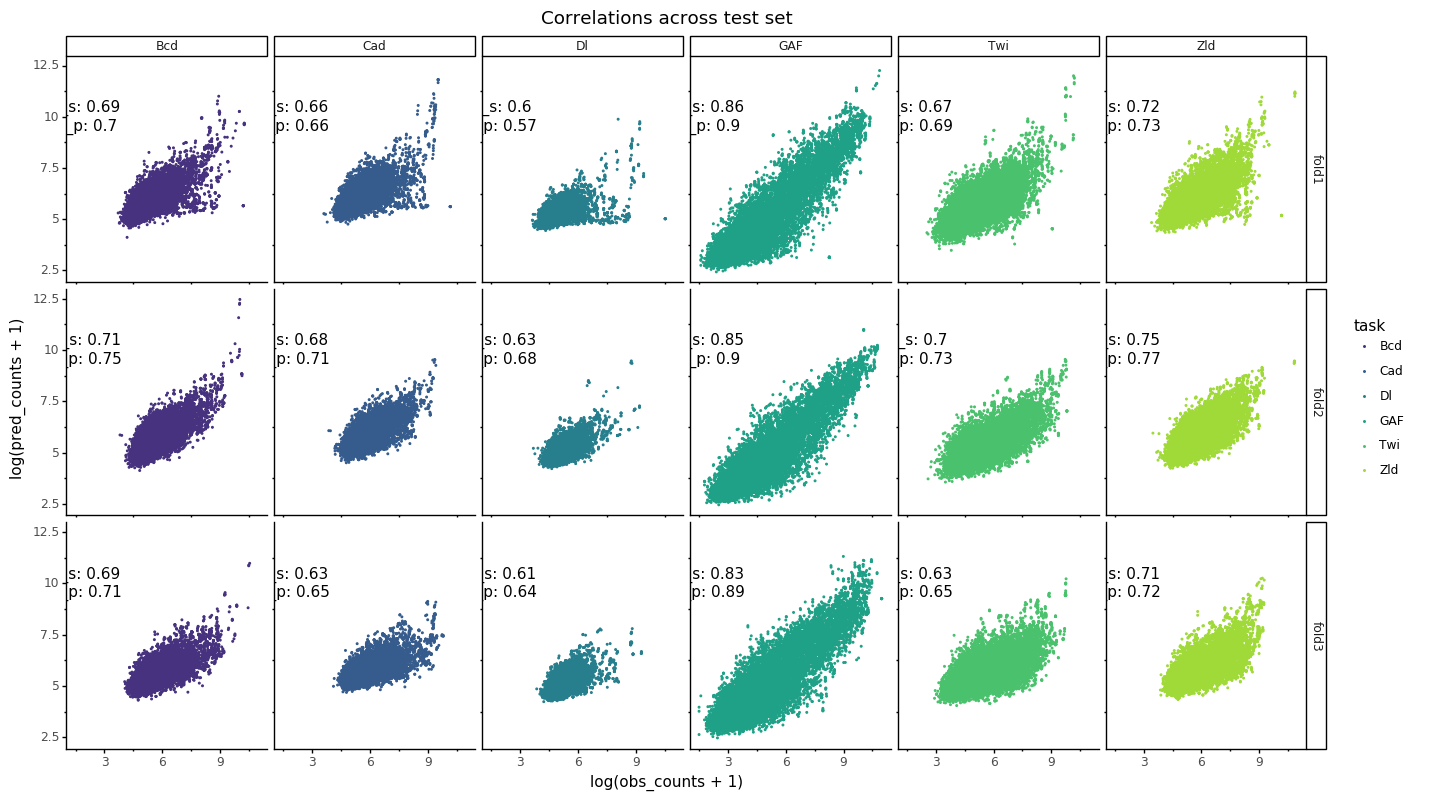

<ggplot: (8755575560042)>


In [35]:
import seaborn as sns
plotnine.options.figure_size = (16,9)

corr_plot = (ggplot(data = counts_df, mapping = aes('obs','pred'))+
    geom_point(aes(color = 'task'), size = .2)+
    geom_text(data = corr_df, mapping = aes(x = 1.5, y = 10, label = 'txt'))+
    scale_x_continuous(name = 'log(obs_counts + 1)')+
    scale_y_continuous(name = 'log(pred_counts + 1)')+
    scale_color_manual(values = sns.color_palette('viridis', n_colors = len(tasks)).as_hex())+
    facet_grid('fold ~ task')+
    ggtitle(f'Correlations across test set')+
    theme_classic())

corr_plot.save(f'{figure_filepath}/corr_test_regions.png', height = 9, width = 16)
corr_plot.save(f'{figure_filepath}/corr_test_regions.pdf', height = 9, width = 16)
print(corr_plot)

## Calculate replicate and metapeak auPRC 

In [36]:
#Calulcate auPRC values for this model
pos_min_thresh = 0.015
neg_max_thresh = 0.005

auprc_df = pd.DataFrame()
for fold in range(1,4):
    for task in tqdm(tasks):

        #Filtering regions if we decide to do this method.
        # task_idx = np.where(data['metadata']['interval_from_task'] == f'{task}')[0] #only get task-specific regions from tasks
        task_idx = range(data_dict[f'fold{fold}']['y_obs'][f'{task}/profile'].shape[0]) #get all regions from tasks

        #Observed versus predicted signal
        o_vs_p_df = eval_profile(yt = data_dict[f'fold{fold}']['y_obs'][f'{task}/profile'][task_idx], 
                                 yp = data_dict[f'fold{fold}']['y_pred'][task][task_idx],
                                 pos_min_threshold=pos_min_thresh, neg_max_threshold=neg_max_thresh,
                                 required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
        o_vs_p_df['type']='obs_vs_pred'

        #Replicate 1 vs replicate 2
        r1_vs_r2_df = eval_profile(yt = data_dict[f'fold{fold}']['rep1_obs'][f'{task}'][task_idx], 
                                   yp = data_dict[f'fold{fold}']['rep2_obs'][f'{task}'][task_idx],
                                   pos_min_threshold=pos_min_thresh, neg_max_threshold=neg_max_thresh,
                                   required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
        r1_vs_r2_df['type']='rep1_vs_rep2'

        #Observed versus metpeak signal
        o_vs_mp_df = eval_profile(yt = data_dict[f'fold{fold}']['y_obs'][f'{task}/profile'][task_idx], 
                                  yp = data_dict[f'fold{fold}']['y_mp'][f'{task}'][task_idx],
                                  pos_min_threshold=pos_min_thresh, neg_max_threshold=neg_max_thresh,
                                  required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
        o_vs_mp_df['type']='obs_vs_metapeak'

        #Observed versus randomly shuffled signal
        o_vs_r_df = o_vs_p_df.copy()
        o_vs_r_df['auprc'] = o_vs_r_df['random_auprc']
        o_vs_r_df['type']='obs_vs_random'

        df = pd.concat([o_vs_p_df, r1_vs_r2_df, o_vs_mp_df, o_vs_r_df])
        df['task'] = task
        df['fold'] = f'fold{fold}'
        auprc_df = auprc_df.append(df)

100%|██████████| 6/6 [21:01<00:00, 210.21s/it]


In [37]:
auprc_df

,binsize,auprc,random_auprc,n_positives,frac_ambigous,imbalance,type,task,fold
0,1,0.080760,0.001250,28652,0.050398,0.001269,obs_vs_pred,Zld,fold1
1,2,0.126529,0.002453,27144,0.087876,0.002504,obs_vs_pred,Zld,fold1
2,4,0.204495,0.004888,25504,0.143601,0.005012,obs_vs_pred,Zld,fold1
3,10,0.351844,0.012528,23085,0.243207,0.012834,obs_vs_pred,Zld,fold1
4,20,0.495712,0.025637,20959,0.328408,0.026260,obs_vs_pred,Zld,fold1
5,50,0.684082,0.066908,17828,0.439789,0.066947,obs_vs_pred,Zld,fold1
6,100,0.792225,0.134776,15437,0.520195,0.135365,obs_vs_pred,Zld,fold1
0,1,0.129207,0.002234,25515,0.056941,0.002198,rep1_vs_rep2,Zld,fold1
1,2,0.202041,0.004448,24278,0.098646,0.004376,rep1_vs_rep2,Zld,fold1
2,4,0.339727,0.009016,22714,0.158879,0.008775,rep1_vs_rep2,Zld,fold1


Plot the auPRC values of actual data for reference.

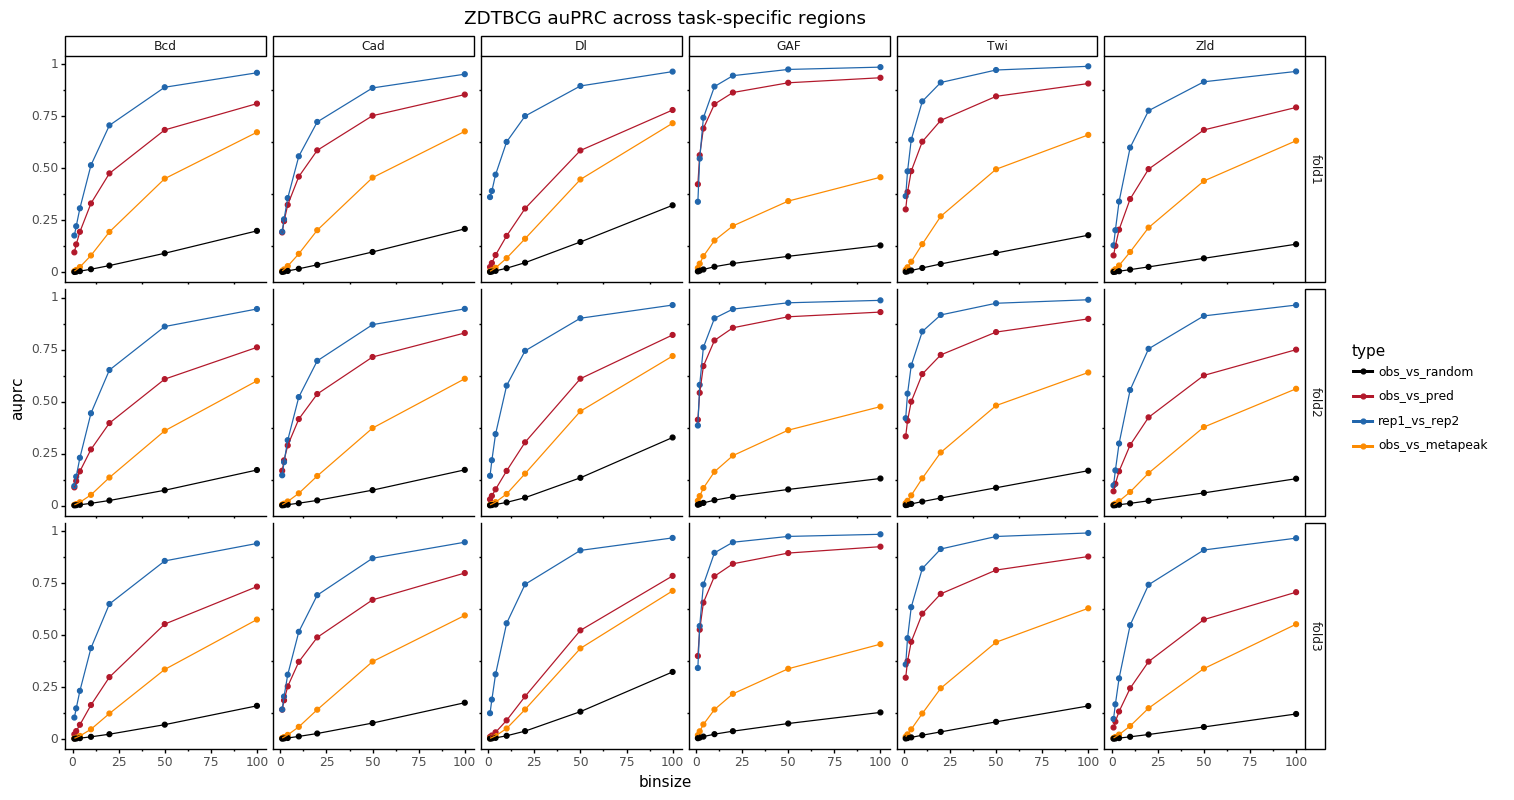

<ggplot: (8754288764259)>


In [38]:
%matplotlib inline
plotnine.options.figure_size = (16,9)

auprc_df['type'] = pd.Categorical(auprc_df['type'], 
                                  categories=['obs_vs_random', 'obs_vs_pred', 'rep1_vs_rep2', 'obs_vs_metapeak'], 
                                  ordered=False)

auprc_plot = (ggplot(data = auprc_df, mapping = aes(x = 'binsize',y='auprc'))+
    geom_point(mapping = aes(color = 'type'))+
    geom_line(mapping = aes(color = 'type'))+
    scale_color_manual(values = ['#000000', '#b2182b', '#2166ac', '#fc8b01'])+
    facet_grid('fold ~ task')+
    ggtitle('ZDTBCG auPRC across task-specific regions')+
    theme_classic())
auprc_plot.save(f'{figure_filepath}/auprc_test_regions.png', height = 9, width = 16)
auprc_plot.save(f'{figure_filepath}/auprc_test_regions.pdf', height = 9, width = 16)
print(auprc_plot)